In [46]:
import joblib
import nltk
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from data_process import get_dataframe
import matplotlib.pyplot as plt
from data_process import get_embeddings_tfidf
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from deep_learning.TextCNN.model import textCNN
import pickle
import torch
from deep_learning.dataset import Vocabulary, MyDataset

In [2]:
import itertools


def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # print("Normalized confusion matrix")
    else:
        # print('Confusion matrix, without normalization')
        thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.axis("off")

def accuracy(cnfm):  # Correct/total
    return cnfm.trace()/cnfm.sum((0,1))

def recalls(cnfm):
    return np.diag(cnfm)/cnfm.sum(1)  #

def precisions(cnfm):
    return np.diag(cnfm)/cnfm.sum(0)

In [3]:
def confusionMatrices(net, dataset_loader, nclasses=2):
    cnfm = np.zeros((nclasses, nclasses), dtype=int)

    # work without gradient computation since we are testing (i.e. no optimisation)
    with torch.no_grad():  # 测试集不需要梯度计算
        for data in dataset_loader:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)

            # find the class with the highest output.
            # note that the outputs are confidence values since we didn't need to apply softmax in our network
            # (nn.crossentropyloss takes raw condifence values and does its own softmax)
            _, predicted = torch.max(outputs, 1)

            # accumulate into confusion matrix
            for i in range(labels.size(0)):
                cnfm[labels[i].item(), predicted[i].item()] += 1
    return cnfm

In [4]:
df = get_dataframe()
df.head()

,text,label
0,dont think argument credibly made united state...,1
1,c mo ser estados unidos con donald trump de pr...,1
2,like little crew bandits first raccoon face po...,0
3,written ron paul sunday november 13 2016 distu...,1
4,yves smith unprecedented election season final...,1


In [5]:
# label:1, 0 (1: unreliable; 0: reliable)
df.label.value_counts()

1    16899
0    14025
Name: label, dtype: int64

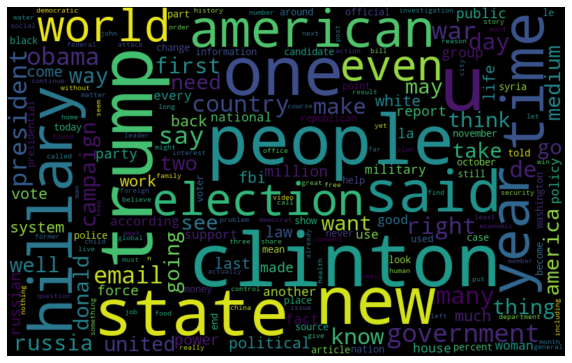

In [6]:
# 1 fake wordcloud
fake_data = df[df["label"] == 1]
all_words = ' '.join([text for text in fake_data.text])
wordcloud = WordCloud(width= 800, height= 500,max_font_size = 110,collocations = False).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


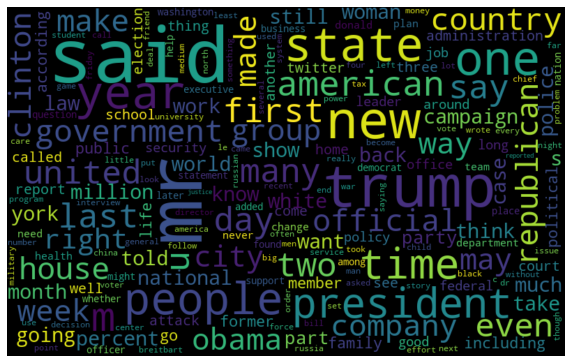

In [7]:
# 0 real wordcloud
real_data = df[df["label"] == 0]
all_words = ' '.join([text for text in real_data.text])
wordcloud = WordCloud(width= 800, height= 500,max_font_size = 110,collocations = False).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Get Embedding data

In [8]:
x_test_doc2vec = np.load('./x_test_doc2vec.npy')
y_true = np.load('./y_test_doc2vec.npy')

x_test_word2vec = np.load('./x_test_word2vec.npy')

_, x_test_tf_idf, _, _ = get_embeddings_tfidf("./dataset")

Load Model

In [67]:
svm_tfidf = joblib.load('./machine learning/svm_tfidf.pkl')
svm_word2vec = joblib.load('./machine learning/svm_word2vec.pkl')
svm_doc2vec = joblib.load('./machine learning/svm_doc2vec.pkl')

rf_tfidf = joblib.load('./machine learning/rf_tfidf.pkl')
rf_doc2vec = joblib.load('./machine learning/rf_doc2vec.pkl')
rf_word2vec = joblib.load('./machine learning/rf_word2vec.pkl')

tree_tfidf = joblib.load('./machine learning/tree_tfidf.pkl')
tree_doc2vec = joblib.load('./machine learning/tree_doc2vec.pkl')
tree_word2vec = joblib.load('./machine learning/tree_word2vec.pkl')

knn_tfidf = joblib.load('./machine learning/knn_tfidf.pkl')
knn_doc2vec = joblib.load('./machine learning/knn_doc2vec.pkl')
knn_word2vec = joblib.load('./machine learning/knn_word2vec.pkl')

svm predict

In [10]:
svm_tfidf_predict = svm_tfidf.predict(x_test_tf_idf)
svm_word2vec_predict = svm_word2vec.predict(x_test_word2vec)
svm_doc2vec_predict = svm_doc2vec.predict(x_test_doc2vec)

TF-IDF + SVM, Accuracy: 85.17%, Recall:  95.56%


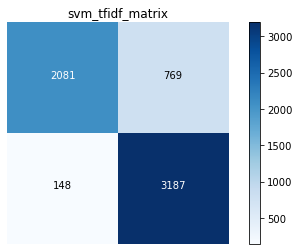

In [11]:
svm_tfidf_matrix = confusion_matrix(y_true,svm_tfidf_predict)
print(f"TF-IDF + SVM, Accuracy: {accuracy(svm_tfidf_matrix)*100:.2f}%, Recall: {recalls(svm_tfidf_matrix)[1] * 100: .2f}%")
plot_confusion_matrix(svm_tfidf_matrix, ["real", "fake"], title="svm_tfidf_matrix")

Word2vec + SVM, Accuracy: 82.83%, Recall:  89.57%


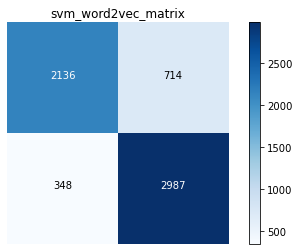

In [12]:
svm_word2vec_matrix = confusion_matrix(y_true,svm_word2vec_predict)
print(f"Word2vec + SVM, Accuracy: {accuracy(svm_word2vec_matrix)*100:.2f}%, Recall: {recalls(svm_word2vec_matrix)[1] * 100: .2f}%")
plot_confusion_matrix(svm_word2vec_matrix, ["real", "fake"], title="svm_word2vec_matrix")

Doc2vec + SVM, Accuracy: 80.94%, Recall:  95.53%


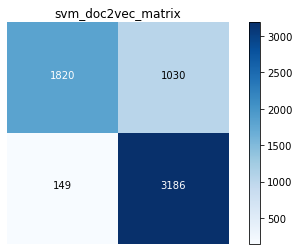

In [13]:
svm_doc2vec_matrix = confusion_matrix(y_true,svm_doc2vec_predict)
print(f"Doc2vec + SVM, Accuracy: {accuracy(svm_doc2vec_matrix)*100:.2f}%, Recall: {recalls(svm_doc2vec_matrix)[1] * 100: .2f}%")
plot_confusion_matrix(svm_doc2vec_matrix, ["real", "fake"], title="svm_doc2vec_matrix")

DecisionTree predict

In [14]:
tree_tfidf_predict = tree_tfidf.predict(x_test_tf_idf)
tree_word2vec_predict = tree_word2vec.predict(x_test_word2vec)
tree_doc2vec_predict = tree_doc2vec.predict(x_test_doc2vec)

TF-IDF + DecisionTree, Accuracy: 78.79%, Recall:  81.29%


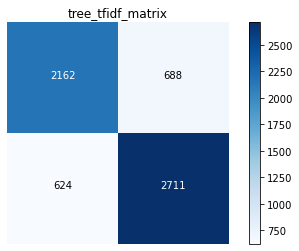

In [15]:
tree_tfidf_matrix = confusion_matrix(y_true,tree_tfidf_predict)
print(f"TF-IDF + DecisionTree, Accuracy: {accuracy(tree_tfidf_matrix)*100:.2f}%, Recall: {recalls(tree_tfidf_matrix)[1] * 100: .2f}%")
plot_confusion_matrix(tree_tfidf_matrix, ["real", "fake"], title="tree_tfidf_matrix")

Word2vec + DecisionTree, Accuracy: 72.26%, Recall:  73.70%


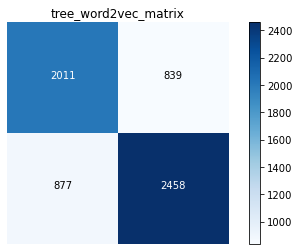

In [16]:
tree_word2vec_matrix = confusion_matrix(y_true,tree_word2vec_predict)
print(f"Word2vec + DecisionTree, Accuracy: {accuracy(tree_word2vec_matrix)*100:.2f}%, Recall: {recalls(tree_word2vec_matrix)[1] * 100: .2f}%")
plot_confusion_matrix(tree_word2vec_matrix, ["real", "fake"], title="tree_word2vec_matrix")

Doc2vec + DecisionTree, Accuracy: 69.18%, Recall:  72.98%


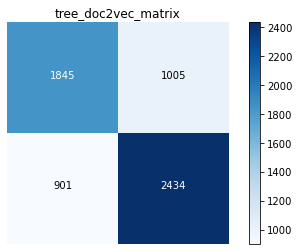

In [17]:
tree_doc2vec_matrix = confusion_matrix(y_true,tree_doc2vec_predict)
print(f"Doc2vec + DecisionTree, Accuracy: {accuracy(tree_doc2vec_matrix)*100:.2f}%, Recall: {recalls(tree_doc2vec_matrix)[1] * 100: .2f}%")
plot_confusion_matrix(tree_doc2vec_matrix, ["real", "fake"], title="tree_doc2vec_matrix")

RandomForest predict

In [18]:
RF_tfidf_predict = rf_tfidf.predict(x_test_tf_idf)
RF_word2vec_predict = rf_word2vec.predict(x_test_word2vec)
RF_doc2vec_predict = rf_doc2vec.predict(x_test_doc2vec)

TF-IDF + RandomForest, Accuracy: 83.56%, Recall:  92.14%


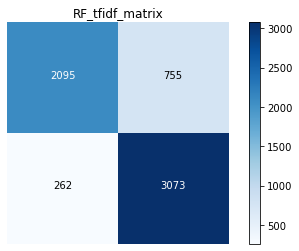

In [19]:
RF_tfidf_matrix = confusion_matrix(y_true,RF_tfidf_predict)
print(f"TF-IDF + RandomForest, Accuracy: {accuracy(RF_tfidf_matrix)*100:.2f}%, Recall: {recalls(RF_tfidf_matrix)[1] * 100: .2f}%")
plot_confusion_matrix(RF_tfidf_matrix, ["real", "fake"], title="RF_tfidf_matrix")

Word2vec + RandomForest, Accuracy: 81.21%, Recall:  91.03%


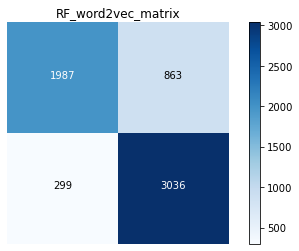

In [20]:
RF_word2vec_matrix = confusion_matrix(y_true,RF_word2vec_predict)
print(f"Word2vec + RandomForest, Accuracy: {accuracy(RF_word2vec_matrix)*100:.2f}%, Recall: {recalls(RF_word2vec_matrix)[1] * 100: .2f}%")
plot_confusion_matrix(RF_word2vec_matrix, ["real", "fake"], title="RF_word2vec_matrix")

Doc2vec + RandomForest, Accuracy: 80.13%, Recall:  91.96%


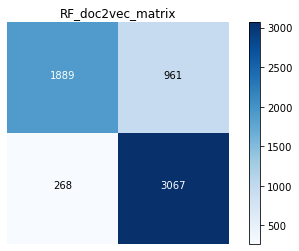

In [21]:
RF_doc2vec_matrix = confusion_matrix(y_true,RF_doc2vec_predict)
print(f"Doc2vec + RandomForest, Accuracy: {accuracy(RF_doc2vec_matrix)*100:.2f}%, Recall: {recalls(RF_doc2vec_matrix)[1] * 100: .2f}%")
plot_confusion_matrix(RF_doc2vec_matrix, ["real", "fake"], title="RF_doc2vec_matrix")

KNN

In [30]:
KNN_tfidf_predict = knn_tfidf.predict(x_test_tf_idf)
KNN_word2vec_predict = knn_word2vec.predict(x_test_word2vec)
KNN_doc2vec_predict = knn_doc2vec.predict(x_test_doc2vec)

TF-IDF + KNN, Accuracy: 58.46%, Recall:  99.46%


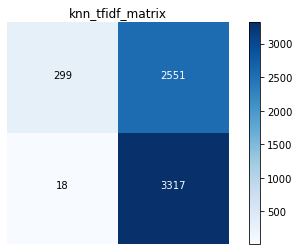

In [31]:
knn_tfidf_matrix = confusion_matrix(y_true,KNN_tfidf_predict)
print(f"TF-IDF + KNN, Accuracy: {accuracy(knn_tfidf_matrix)*100:.2f}%, Recall: {recalls(knn_tfidf_matrix)[1] * 100: .2f}%")
plot_confusion_matrix(knn_tfidf_matrix, ["real", "fake"], title="knn_tfidf_matrix")

Word2vec + KNN, Accuracy: 76.48%, Recall:  73.58%


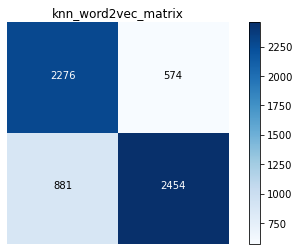

In [32]:
knn_word2vec_matrix = confusion_matrix(y_true,KNN_word2vec_predict)
print(f"Word2vec + KNN, Accuracy: {accuracy(knn_word2vec_matrix)*100:.2f}%, Recall: {recalls(knn_word2vec_matrix)[1] * 100: .2f}%")
plot_confusion_matrix(knn_word2vec_matrix, ["real", "fake"], title="knn_word2vec_matrix")

Doc2vec + KNN, Accuracy: 77.17%, Recall:  85.58%


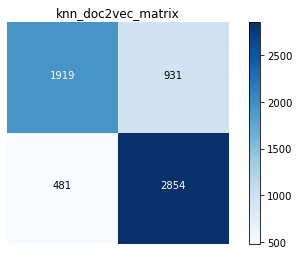

In [33]:
knn_doc2vec_matrix = confusion_matrix(y_true,KNN_doc2vec_predict)
print(f"Doc2vec + KNN, Accuracy: {accuracy(knn_doc2vec_matrix)*100:.2f}%, Recall: {recalls(knn_doc2vec_matrix)[1] * 100: .2f}%")
plot_confusion_matrix(knn_doc2vec_matrix, ["real", "fake"], title="knn_doc2vec_matrix")

TextCNN

In [22]:
with open('./dataset/vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)

test_df = pd.read_hdf(f'./dataset/test_df.h5', 'df')
test_set = MyDataset(test_df, vocab)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=64, shuffle=True)

textCNN_d = torch.load('./deep_learning/TextCNN/results/TextCNN.pt')
textCNN_model = textCNN(vocab_size=len(vocab), embedding_dim=300, out_dim=100, kernel_wins=[3, 4, 5], num_class=2)
textCNN_model.load_state_dict(textCNN_d["state_dict"])
textCNN_model = textCNN_model.cuda()

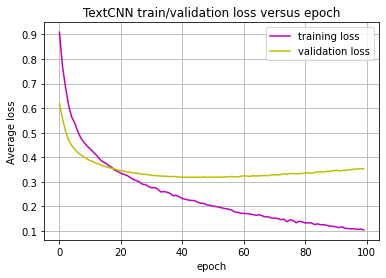

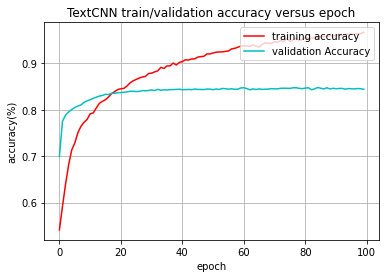

In [85]:
textCNN_statsrec = textCNN_d["stats"]

plt.figure()
plt.title("TextCNN train/validation loss versus epoch")
plt.xlabel("epoch")
plt.ylabel("Average loss")
plt.plot(textCNN_statsrec[0], 'm', label = 'training loss')
plt.plot(textCNN_statsrec[2], 'y', label = 'validation loss' )
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


plt.figure()
plt.title("TextCNN train/validation accuracy versus epoch")
plt.xlabel("epoch")
plt.ylabel("accuracy(%)")
plt.plot(textCNN_statsrec[1], 'r', label = 'training accuracy')
plt.plot(textCNN_statsrec[3], 'c', label = 'validation Accuracy' )
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [25]:
select_textCNN_d = torch.load('./deep_learning/TextCNN/results/TextCNN_19_loss_ 0.348_acc_ 83.7%.pt')
select_textCNN_model = textCNN(vocab_size=len(vocab), embedding_dim=300, out_dim=100, kernel_wins=[3, 4, 5], num_class=2)
select_textCNN_model.load_state_dict(select_textCNN_d["state_dict"])
select_textCNN_model = select_textCNN_model.cuda()

textcnn_matrice = confusionMatrices(select_textCNN_model, test_loader)
textcnn_matrice

array([[1977,  789],
       [ 485, 2933]])

TextCNN, Accuracy: 79.40%, Recall:  85.81%


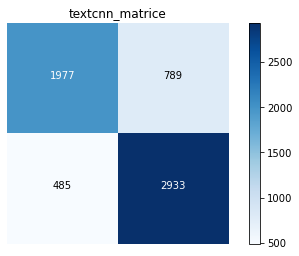

In [26]:
print(f"TextCNN, Accuracy: {accuracy(textcnn_matrice)*100:.2f}%, Recall: {recalls(textcnn_matrice)[1] * 100: .2f}%")
plot_confusion_matrix(textcnn_matrice, ["real", "fake"], title="textcnn_matrice")

LSTM

In [34]:
from deep_learning.LSTM.model import LSTM
with open('./dataset/vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)


LSTM_d = torch.load('./deep_learning/LSTM/results/LSTM.pt')
LSTM_model = LSTM(embedding_dim=100, hidden_dim=256, vocab_size=len(vocab), num_layers=2, n_class=2, bidirectional=True)
LSTM_model.load_state_dict(LSTM_d["state_dict"])
LSTM_model = LSTM_model.cuda()

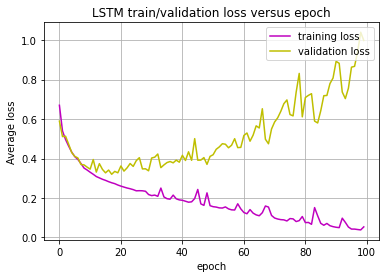

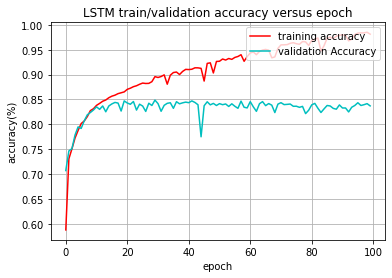

In [86]:
LSTM_statsrec = LSTM_d["stats"]

plt.figure()
plt.title("LSTM train/validation loss versus epoch")
plt.xlabel("epoch")
plt.ylabel("Average loss")
plt.plot(LSTM_statsrec[0], 'm', label = 'training loss')
plt.plot(LSTM_statsrec[2], 'y', label = 'validation loss' )
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

plt.figure()
plt.title("LSTM train/validation accuracy versus epoch")
plt.xlabel("epoch")
plt.ylabel("accuracy(%)")
plt.plot(LSTM_statsrec[1], 'r', label = 'training accuracy')
plt.plot(LSTM_statsrec[3], 'c', label = 'validation Accuracy' )
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [40]:
select_LSTM_d = torch.load('./deep_learning/LSTM/results/LSTM_10_loss_ 0.346_acc_ 83.5%.pt')
select_LSTM_model = LSTM(embedding_dim=100, hidden_dim=256, vocab_size=len(vocab), num_layers=2, n_class=2, bidirectional=True)
select_LSTM_model.load_state_dict(select_LSTM_d["state_dict"])
select_LSTM_model = select_LSTM_model.cuda()

lstm_matrice = confusionMatrices(select_LSTM_model, test_loader)
lstm_matrice

array([[1977,  789],
       [ 256, 3162]])

LSTM, Accuracy: 83.10%, Recall:  92.51%


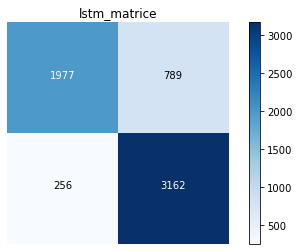

In [41]:
print(f"LSTM, Accuracy: {accuracy(lstm_matrice)*100:.2f}%, Recall: {recalls(lstm_matrice)[1] * 100: .2f}%")
plot_confusion_matrix(lstm_matrice, ["real", "fake"], title="lstm_matrice")

In [77]:
from sklearn.feature_extraction.text import CountVectorizer


def predict(net, text):
    token = nltk.tokenize.word_tokenize(text)
    text_vec = [vocab('<end>') if i == len(token) else (vocab(token[i]) if len(token) > i else vocab('<pad>')) for i
                in range(760)]
    vec = torch.tensor(text_vec)
    vec = vec.reshape(1,-1)

    with torch.no_grad():  # 测试集不需要梯度计算
        vec = vec.cuda()
        outputs = net(vec)
        # find the class with the highest output.
        # note that the outputs are confidence values since we didn't need to apply softmax in our network
        # (nn.crossentropyloss takes raw condifence values and does its own softmax)
        _, predicted = torch.max(outputs, 1)
    return predicted

def get_embeddings_tfidf(text):

    loaded_vec = CountVectorizer(decode_error="replace", vocabulary=pickle.load(open('./word_representation/tf_idf_feature.pkl', "rb")))
    tfidftransformer = pickle.load(open('./word_representation/tfidftransformer.pkl', "rb"))
    #测试用transform，表示测试数据，为list
    matrix = tfidftransformer.transform(loaded_vec.transform([text]))
    return matrix

In [91]:
c = 0
for row in df.itertuples():
    text = getattr(row, 'text')
    label = getattr(row, 'label')
    sample_tf_idf = get_embeddings_tfidf(text)
    sample_knn_tfidf_predict = knn_tfidf.predict(sample_tf_idf)
    sample_knn_tfidf_predict = sample_knn_tfidf_predict[0]
    sample_lstm_predict = predict(select_LSTM_model, text)
    sample_lstm_predict = sample_lstm_predict.item()

    if sample_knn_tfidf_predict != sample_lstm_predict:
        c += 1
        print(f"text: {text}\n label:{label}, KNN+TF_IDF:{sample_knn_tfidf_predict}, LSTM:{sample_lstm_predict}\n")
        if c==5:
            break

text: trump transition team want copy every single executive order directive outgoing president obama ordered immigration since took office along several document let ass beef border security according reuters exclusive famous among executive orders obama unconstitutional shielding illegal alien deportation 2012 carving exemption illegal alien arrived u s minors granted form legal status work permit 1 4 million illegals signed advance parole would let claim u s citizenship completely absent congressional oversight let alone approval trump transition official also asked see illegal alien record changed ensure federal worker altering help illegals stay u s according reuters illegal alien signed amnesty freely gave government addresses identities admission country illegally meaning could first line deportation begin trump administration four year ago pointed fundamental problem deferred action childhood arrival daca program anyone signed daca would adding name list illegal aliens future a